In [1]:
!pip install librosa numpy pandas scikit-learn matplotlib seaborn pyts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 17.8 MB/s eta 0:00:00


## STEP 1: Upload the Dataset

In [2]:
from google.colab import files
import zipfile

uploaded = files.upload()

with zipfile.ZipFile("memotag_voice_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("voice_dataset")


Saving memotag_voice_dataset.zip to memotag_voice_dataset.zip


 ## STEP 2: Load the Transcripts

In [3]:
import pandas as pd

transcripts_df = pd.read_csv("voice_dataset/transcripts.csv")
transcripts_df.head()

,filename,transcript
0,sample_1.wav,"Um, I went to the, uh, store and forgot what I..."
1,sample_2.wav,The quick brown fox jumps over the lazy dog. T...
2,sample_3.wav,"Uh, what's that word, um, when you can't remem..."
3,sample_4.wav,"Today is, uh, a nice day. I think. Or maybe it..."
4,sample_5.wav,My favorite color is blue. Or was it green? I ...


These transcripts are important for extracting linguistic features like:

hesitations (um, uh)

sentence completion

word recall



## STEP 3: Audio Feature Extraction + NLP Features

In [5]:
import librosa
import numpy as np

features = []

for index, row in transcripts_df.iterrows():
    file = row['filename']
    transcript = row['transcript']
    audio_path = f"voice_dataset/{file}"

    y, sr = librosa.load(audio_path, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)


    intervals = librosa.effects.split(y, top_db=30)    # Silence detection
    voiced = sum((end - start) for start, end in intervals) / sr
    silence_ratio = 1 - (voiced / duration)


    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)   # Pitch variability
    pitch_values = pitches[magnitudes > np.median(magnitudes)]
    pitch_mean = np.mean(pitch_values) if len(pitch_values) else 0
    pitch_std = np.std(pitch_values) if len(pitch_values) else 0


    word_count = len(transcript.split())  # NLP features
    hesitation_count = sum(transcript.lower().count(h) for h in ["uh", "um"])
    pause_per_sentence = silence_ratio * 10  # proxy
    speech_rate = word_count / duration
    hesitation_ratio = hesitation_count / word_count if word_count else 0
    sentence_completion = 1 if transcript.endswith(".") else 0

    features.append([
        file, pause_per_sentence, hesitation_ratio, pitch_mean, pitch_std,
        speech_rate, sentence_completion
    ])


These features are often associated with cognitive stress:

More pauses = difficulty forming thoughts

Hesitations = struggling to recall

Lower pitch variability = monotone/dullness

Incomplete sentences = disorientation or stress

## STEP 4: Create Feature Table

In [6]:
feature_df = pd.DataFrame(features, columns=[
    "filename", "pause_score", "hesitation_ratio", "pitch_mean", "pitch_std",
    "speech_rate", "sentence_completion"])
feature_df.head()

,filename,pause_score,hesitation_ratio,pitch_mean,pitch_std,speech_rate,sentence_completion
0,sample_1.wav,0.0,0.187500,439.285217,0.022653,5.333333,1
1,sample_2.wav,0.0,0.071429,439.285217,0.022653,4.666667,1
2,sample_3.wav,0.0,0.142857,439.285217,0.022653,4.666667,1
3,sample_4.wav,0.0,0.076923,439.285217,0.022653,4.333333,0
4,sample_5.wav,0.0,0.000000,439.285217,0.022653,4.333333,1


We use this table as input for ML models to detect anomalies.

##  STEP 5: Normalize and Apply Anomaly Detection

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

X = feature_df.drop(columns=["filename"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
feature_df['PCA1'] = X_pca[:, 0]
feature_df['PCA2'] = X_pca[:, 1]

# Anomaly Detection
iso_forest = IsolationForest(contamination=0.2, random_state=42)
feature_df['anomaly_score'] = iso_forest.fit_predict(X_scaled)

Unsupervised methods help flag potential at-risk speech patterns without needing labeled medical data.

IsolationForest: identifies outliers (possible cognitive decline)

PCA: reduces features to 2D for plotting



## STEP 6: Visualize Risk Scores

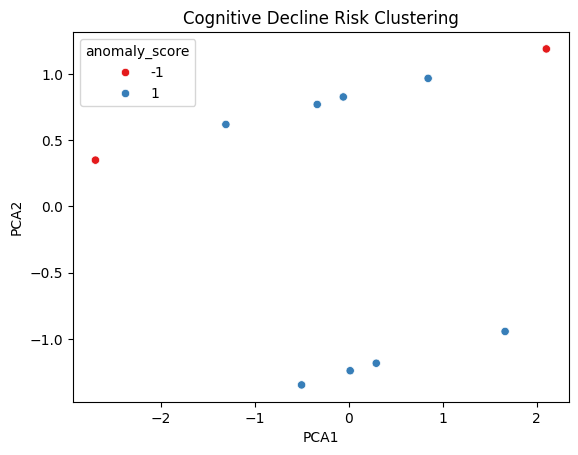

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=feature_df, x="PCA1", y="PCA2", hue="anomaly_score", palette="Set1")
plt.title("Cognitive Decline Risk Clustering")
plt.show()